# Assignment 1

## 1 Plot data

c:\Users\Lenovo\miniconda3\envs\playground\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


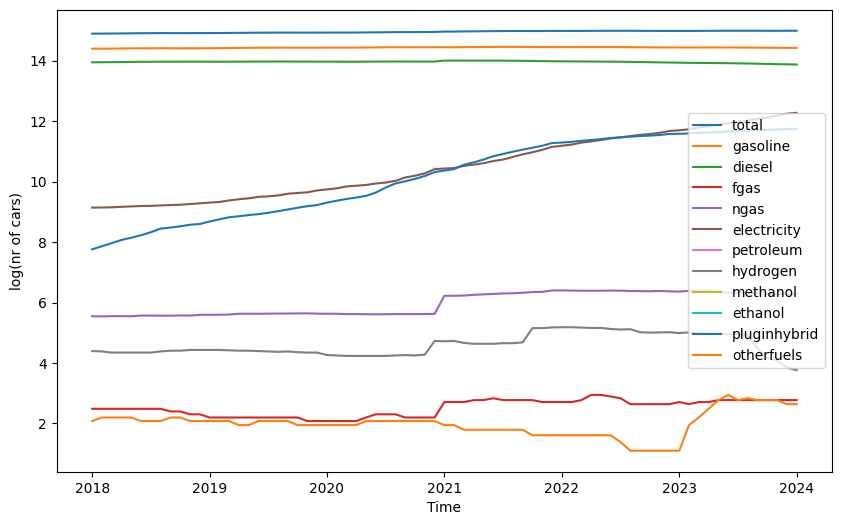

[2018.         2018.08333333 2018.16666667 2018.25       2018.33333333
 2018.41666667 2018.5        2018.58333333 2018.66666667 2018.75
 2018.83333333 2018.91666667 2019.         2019.08333333 2019.16666667
 2019.25       2019.33333333 2019.41666667 2019.5        2019.58333333
 2019.66666667 2019.75       2019.83333333 2019.91666667 2020.
 2020.08333333 2020.16666667 2020.25       2020.33333333 2020.41666667
 2020.5        2020.58333333 2020.66666667 2020.75       2020.83333333
 2020.91666667 2021.         2021.08333333 2021.16666667 2021.25
 2021.33333333 2021.41666667 2021.5        2021.58333333 2021.66666667
 2021.75       2021.83333333 2021.91666667 2022.         2022.08333333
 2022.16666667 2022.25       2022.33333333 2022.41666667 2022.5
 2022.58333333 2022.66666667 2022.75       2022.83333333 2022.91666667
 2023.         2023.08333333 2023.16666667 2023.25       2023.33333333
 2023.41666667 2023.5        2023.58333333 2023.66666667 2023.75
 2023.83333333 2023.91666667 2024.     

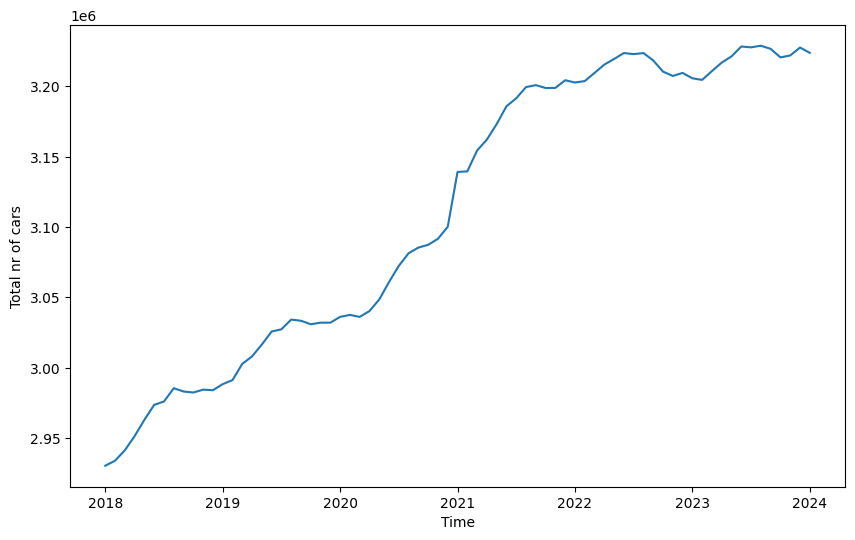

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = pd.read_csv('DST_BIL54.csv')

n = len(df)

labels = df.columns[1:]

time = np.arange(2018, 2018+n/12, 1/12)

df['time'] = time

#split into test and train
train = df[df['time'] < 2024]
test = df[df['time'] >= 2024]


plt.figure(figsize=(10, 6))
#plot the data
for label in labels:
    plt.plot(train['time'], np.log(train[label]), label=label)
plt.xlabel('Time')
plt.ylabel('log(nr of cars)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train['time'], train['total'])
plt.xlabel('Time')
plt.ylabel('Total nr of cars')


print(time)

## 2 Linear trend model

### 2.1

$Y = \theta \cdot X + \epsilon$

$ \begin{bmatrix}
2930483 \\
2934044 \\
2941422 
\end{bmatrix} = \begin{bmatrix}
1 & 2018 \\
1 & 2018.083 \\
1 & 2018.166 
\end{bmatrix} \cdot \begin{bmatrix}
\theta _1 \\
\theta _2 
\end{bmatrix} + \epsilon$


### 2.2, 2.3 and 2.4

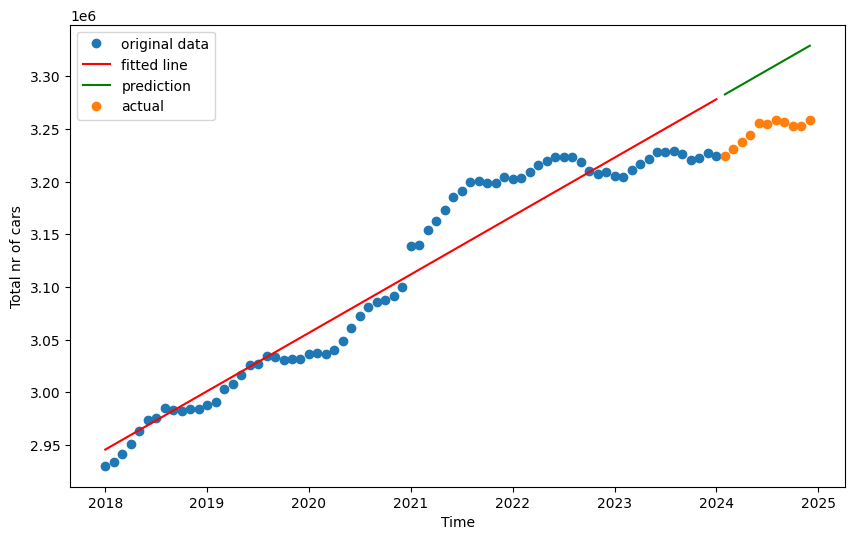

In [35]:
# estimate the trend

N = len(train)

x = np.array([np.ones(N),np.array(train['time'])]).T
y = np.array(train['total'])

x_future = np.array([np.ones(len(test)),np.array(test['time'])]).T
y_future = np.array(test['total'])

reg = LinearRegression(fit_intercept=False)
reg.fit(x, y)

plt.figure(figsize=(10, 6))
plt.plot(x[:,1], y, 'o', label='original data')
plt.plot(x[:,1], (x@reg.coef_.T), 'r', label='fitted line')


prediction = x_future@reg.coef_.T
plt.plot(x_future[:,1], prediction, 'g', label='prediction')
plt.plot(x_future[:,1], y_future, 'o', label='actual')

plt.xlabel('Time')
plt.ylabel('Total nr of cars')
plt.legend()




### 2.5

### 2.6

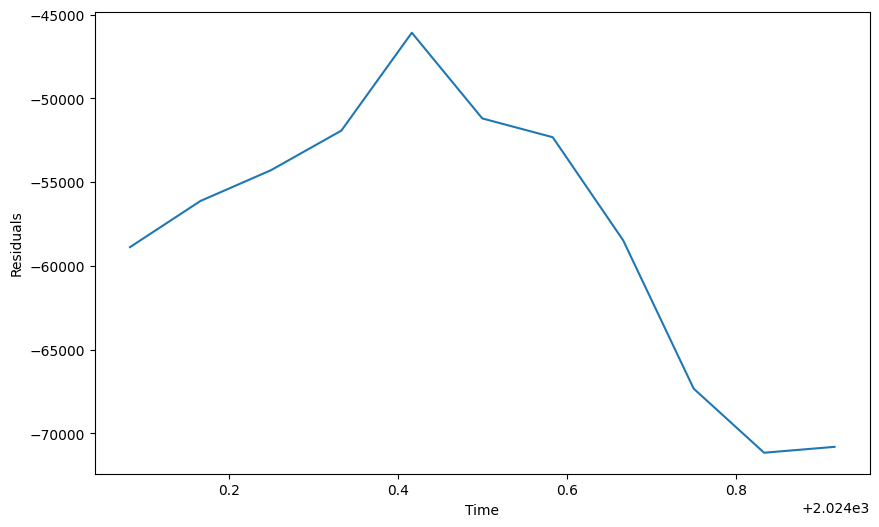

In [45]:
residuals = y_future - prediction
plt.figure(figsize=(10, 6))
# as bars
plt.plot(test['time'], residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')

plt.show()
